## Carregar os dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/Trabalho Reconhecimento de Padroes/dataset_SIN492.parquet'

In [3]:
import pyarrow.parquet as pq
import pandas as pd

tabela_parquet = pq.read_table(dataset_path)
dataframe = tabela_parquet.to_pandas()

# Salvar como arquivo CSV
#dataframe.to_csv('dataset.csv', index=False)


## Análise Inicial e Normalização

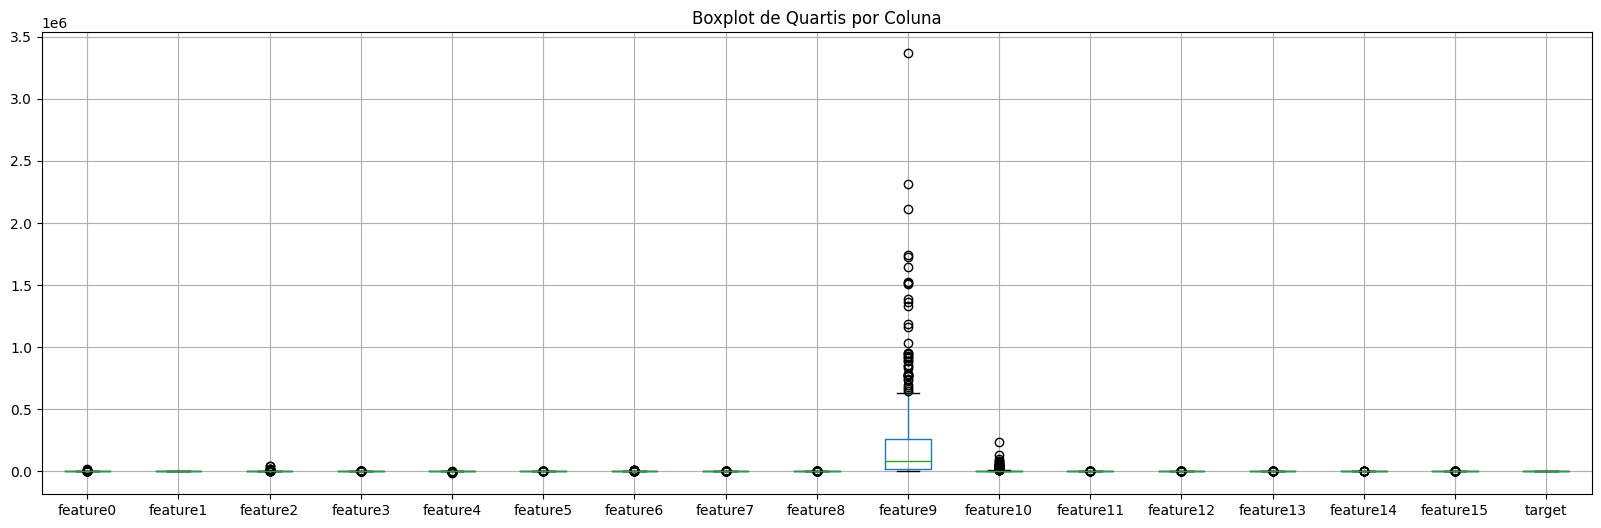

In [4]:
# Plotar boxplots para todas as colunas
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 6))
dataframe.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar os dados usando a escala min-max para ficar no intervalo 0 e 1
df_normalizado = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)


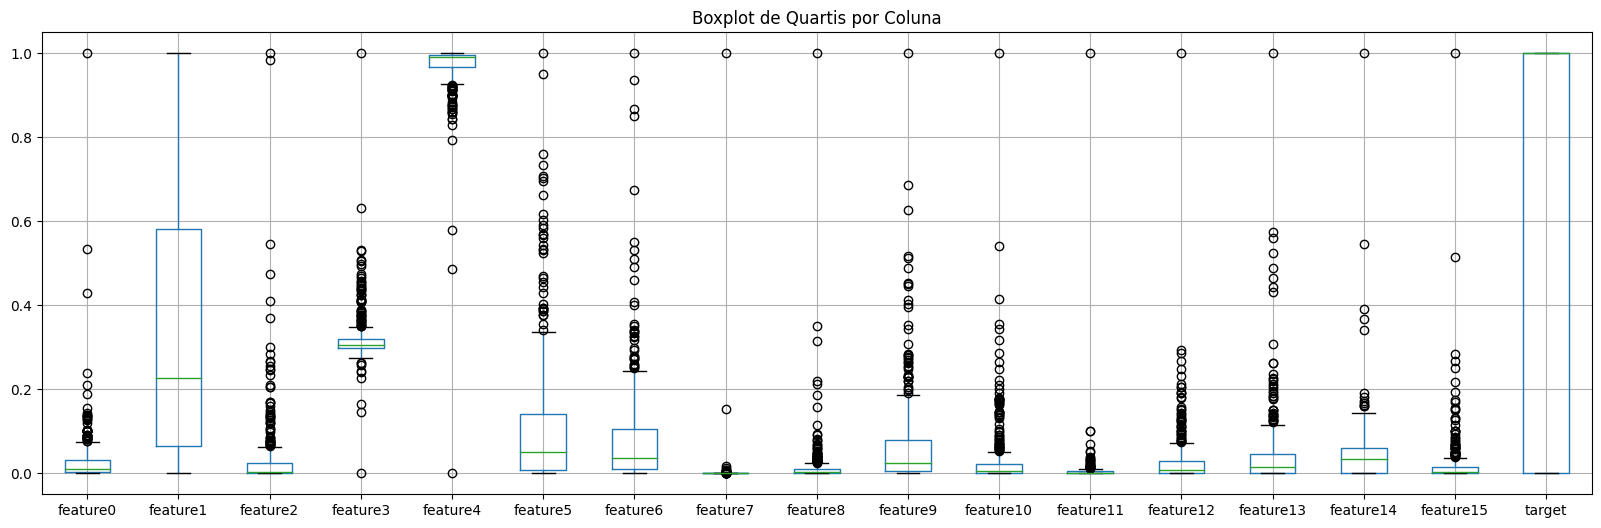

In [6]:
# Plotar boxplots para todas as colunas normalizadas
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 6))
df_normalizado.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

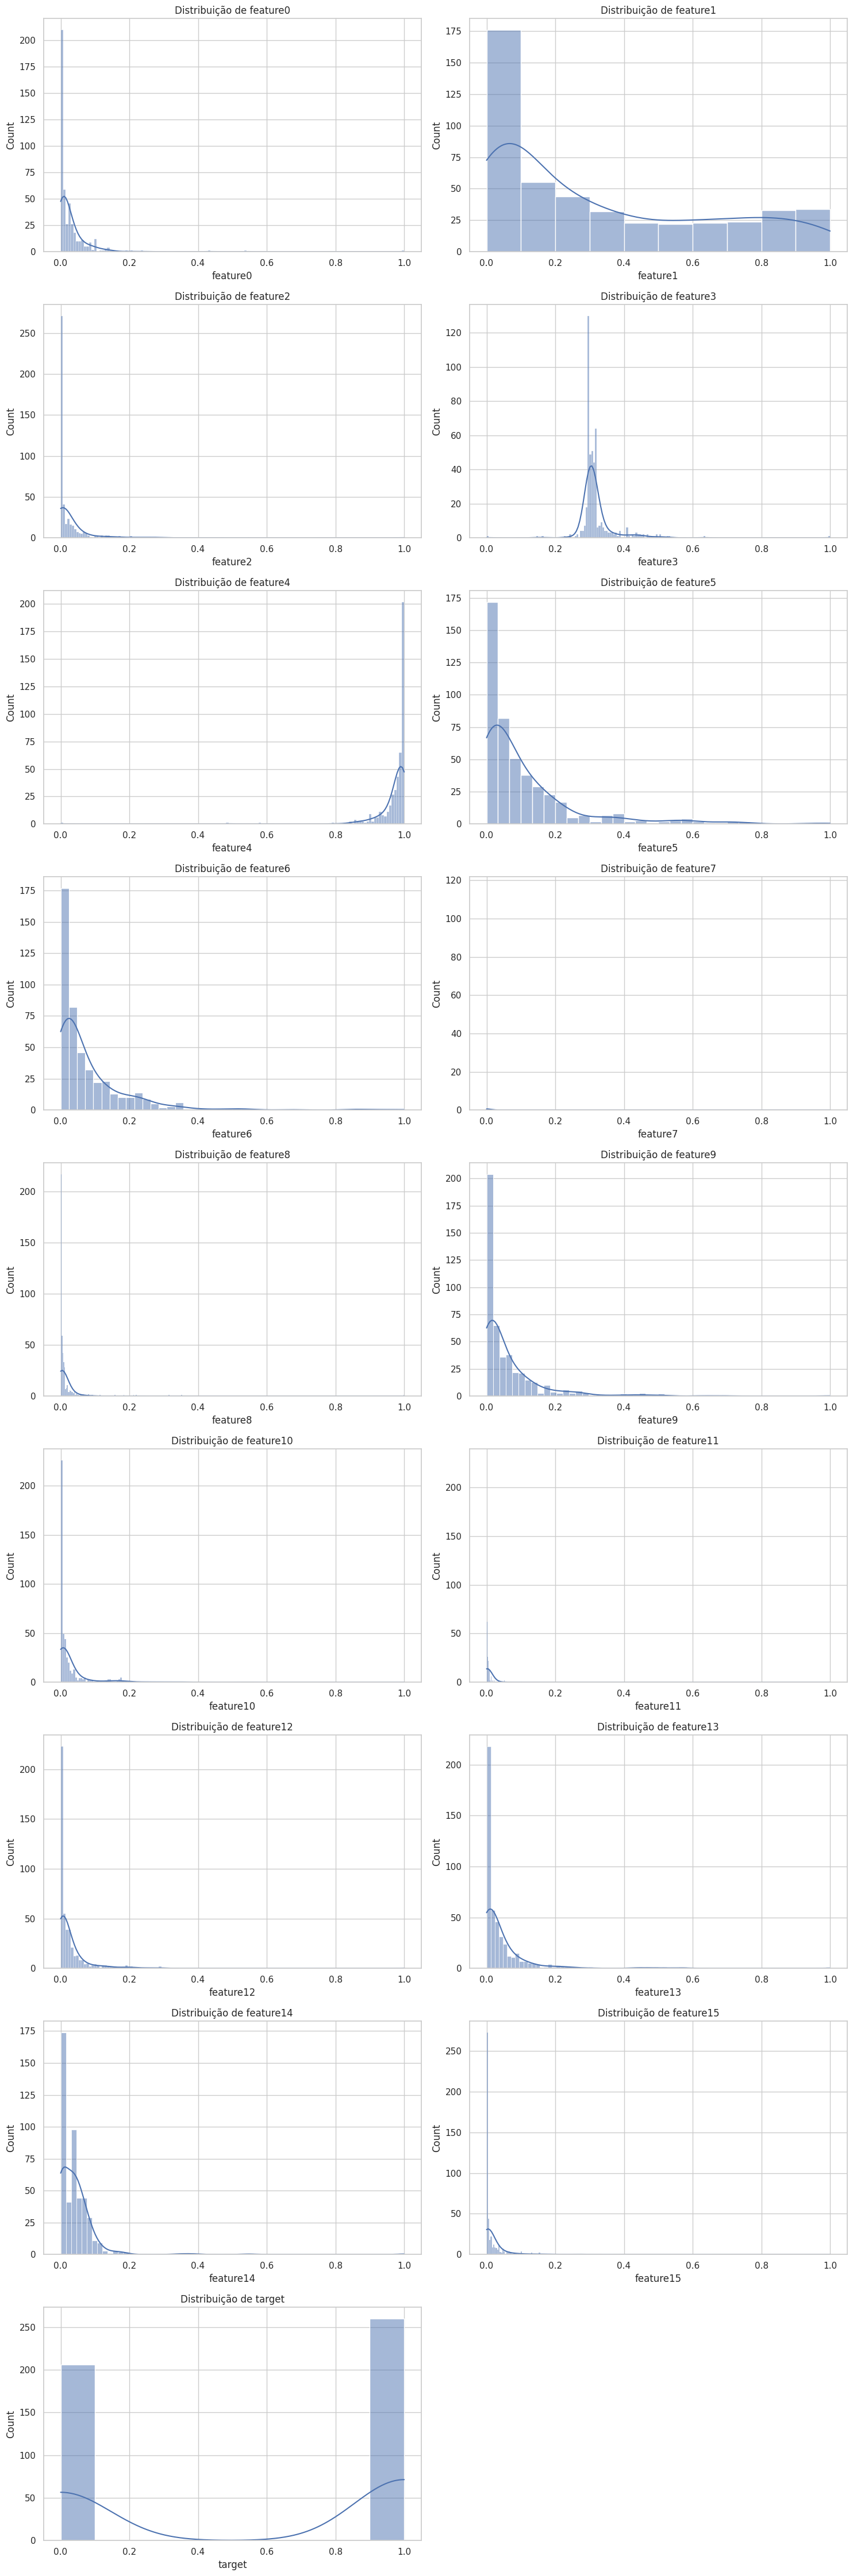

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = df_normalizado

# Configurando o estilo dos gráficos Seaborn
sns.set(style="whitegrid")

# Obtendo o número de colunas no DataFrame
num_cols = len(df.columns)

# Configurando o tamanho da figura com base no número de colunas
num_rows = math.ceil(num_cols / 2)
plt.figure(figsize=(15, 5 * num_rows))

# Loop sobre cada coluna e plotando a distribuição
for i, col in enumerate(df.columns):
    plt.subplot(num_rows, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()
plt.show()


## Remoção de Outliers IQR

In [8]:
# Percebe-se a presença de outliers
# Remover esses outliers atráves de IQR

# Calcule o IQR para cada coluna normalizada
Q1 = df_normalizado.quantile(0.25)
Q3 = df_normalizado.quantile(0.75)
IQR = Q3 - Q1

# Defina um limiar para identificar outliers (por exemplo, 1.5 vezes o IQR)
limiar = 1.6
outliers = ((df_normalizado < (Q1 - limiar * IQR)) | (df_normalizado > (Q3 + limiar * IQR))).any(axis=1)

# Remova as linhas que contêm outliers
df_sem_outliers = df_normalizado[~outliers]


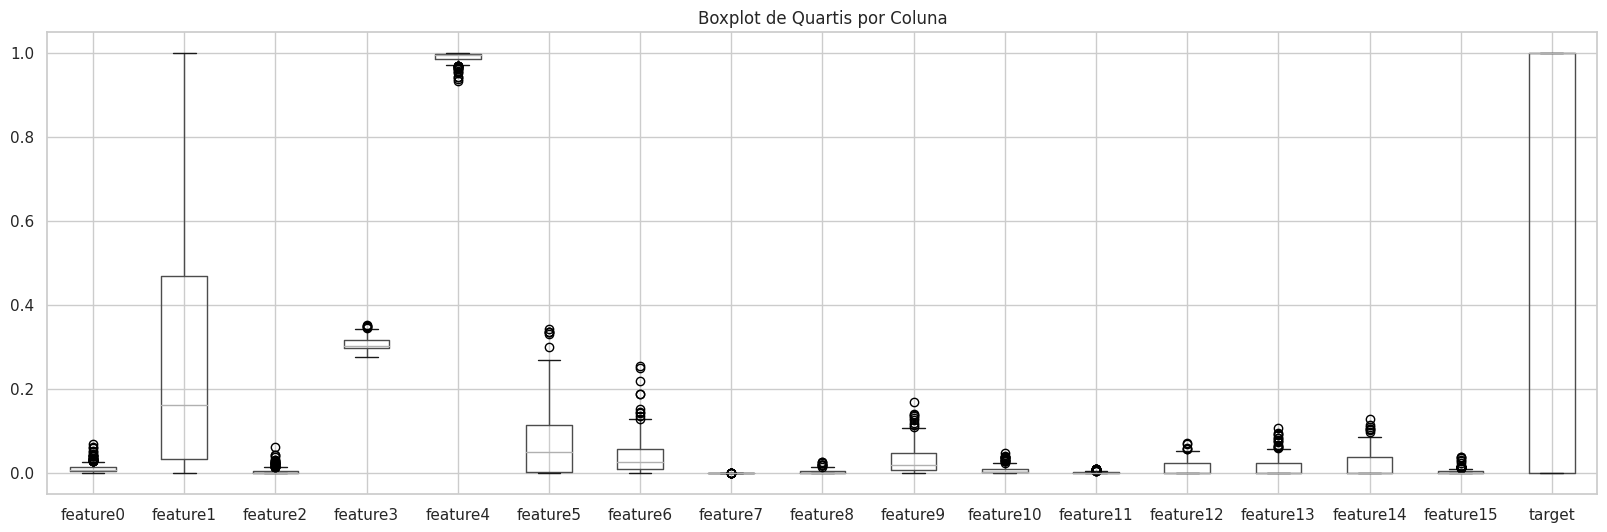

In [9]:
# Plotar boxplots para todas as colunas após remover outliers
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 6))
df_sem_outliers.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

## Seleção de Características

### Visual Analysis

In [10]:
# Deletar algumas colunas que acho que n]ao fazem sentido para os modelos
colunas = ['feature1', 'feature3', 'feature4', 'feature5']
df_visual = df_sem_outliers.drop(columns=colunas)

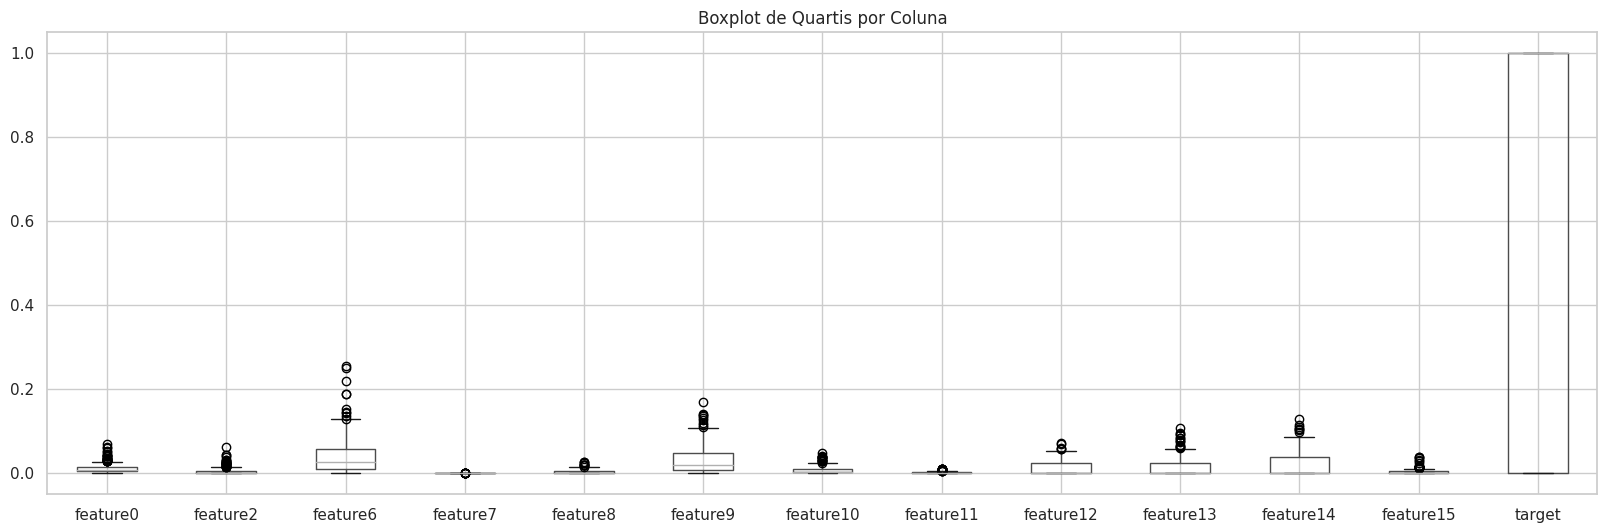

In [11]:
plt.figure(figsize=(20, 6))
df_visual.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

### Feature Importance

In [12]:
from sklearn.ensemble import RandomForestClassifier

X = df_sem_outliers.drop("target", axis=1)
y = df_sem_outliers["target"]

limiar = 0.1

model = RandomForestClassifier()
model.fit(X, y)
feature_importance = model.feature_importances_
best_columns = X.columns[feature_importance > limiar]

df_fi = pd.concat([X[best_columns], df_sem_outliers['target']], axis=1)


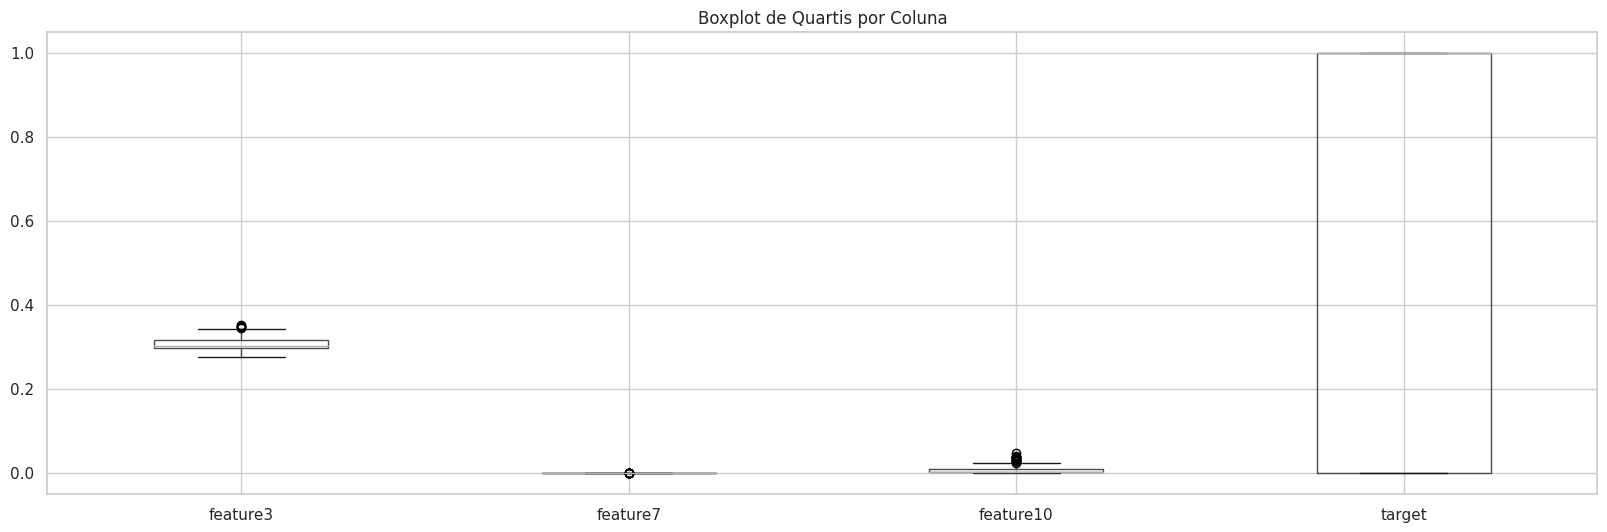

In [13]:
plt.figure(figsize=(20, 6))
df_fi.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

### Univariate Feature Selection

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif  # ou outro teste estatístico relevante

X = df_sem_outliers.drop("target", axis=1)
y = df_sem_outliers["target"]

selector = SelectKBest(score_func=f_classif, k=5)  # Escolha o número desejado de características
fit = selector.fit(X, y)
best_columns = X.columns[fit.get_support()]

df_fs = pd.concat([X[best_columns], df_sem_outliers['target']], axis=1)

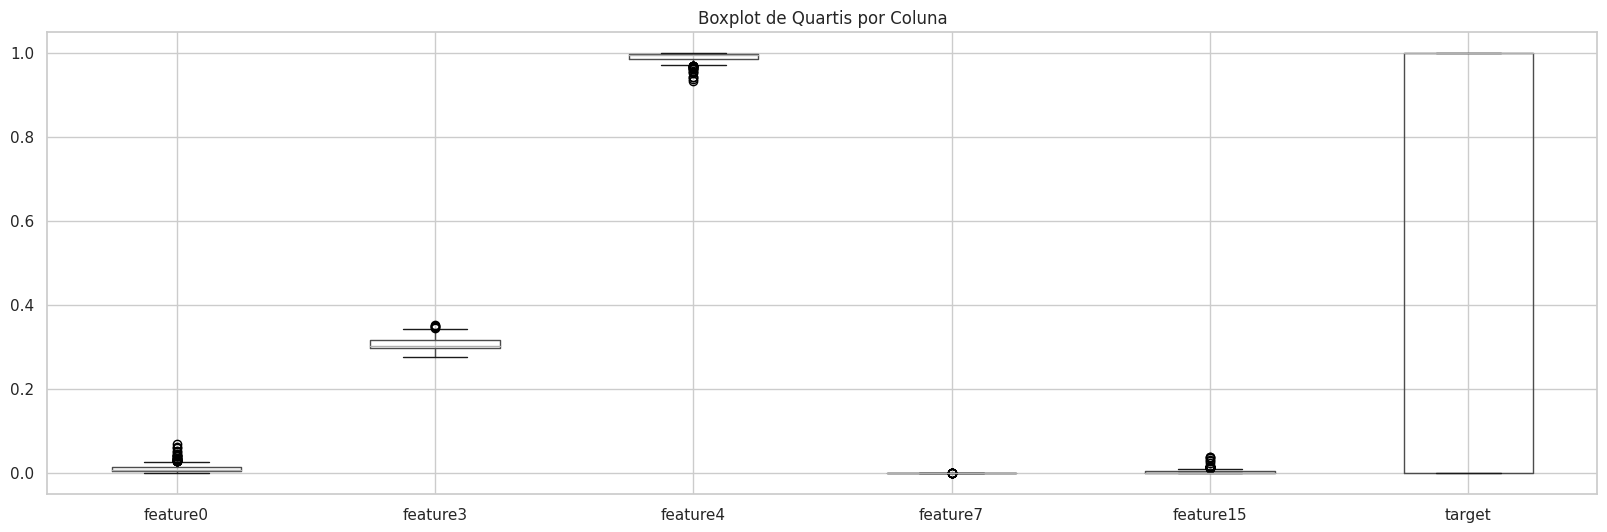

In [15]:
plt.figure(figsize=(20, 6))
df_fs.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

### Recursive Feature Elimination (RFE)

In [16]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


X = df_sem_outliers.drop("target", axis=1)
y = df_sem_outliers["target"]
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=5)  # Escolha o número desejado de características
fit = rfe.fit(X, y)
limiar_rfe = 0.1  # Defina o limiar RFE desejado
best_columns_rfe = X.columns[fit.support_]

df_rfe = pd.concat([X[best_columns_rfe], df_sem_outliers['target']], axis=1)

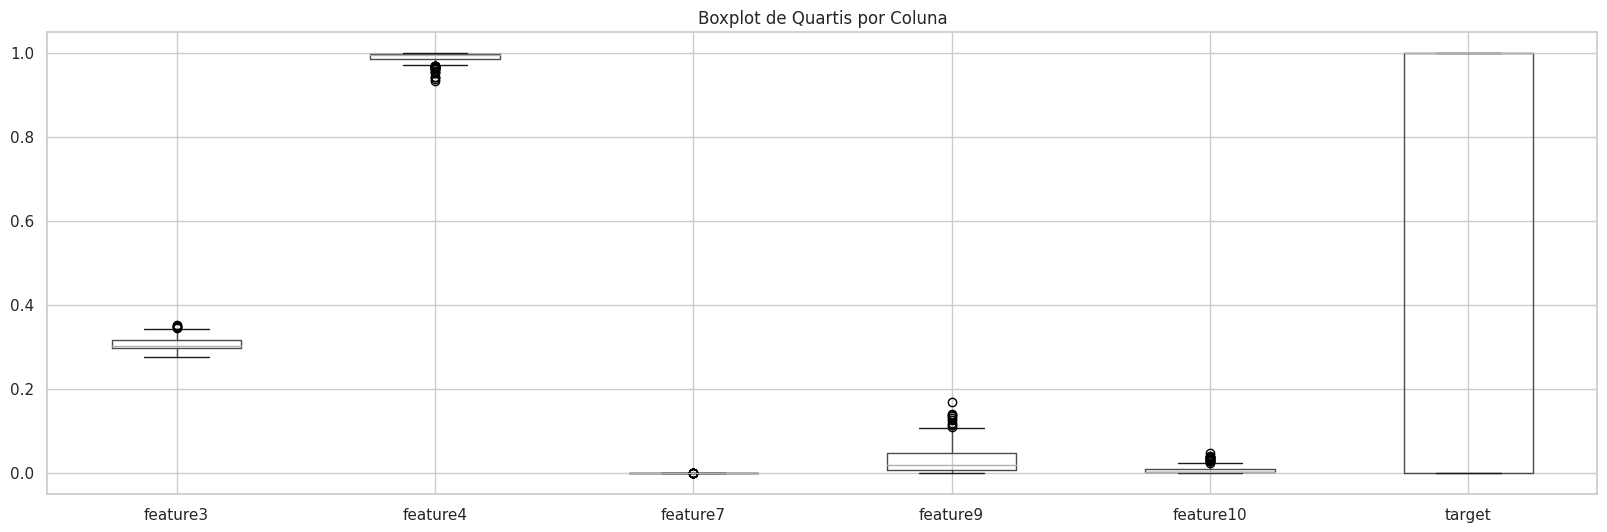

In [17]:
plt.figure(figsize=(20, 6))
df_rfe.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

### Correlation with the Target Variable

In [18]:
correlation_matrix = df_sem_outliers.corr()
target_correlation = correlation_matrix['target'].abs()
limiar_correlacao = 0.11 # Defina o limiar de correlação desejado
best_columns_correlacao = target_correlation[target_correlation > limiar_correlacao].index

df_corr = df_sem_outliers[best_columns_correlacao]

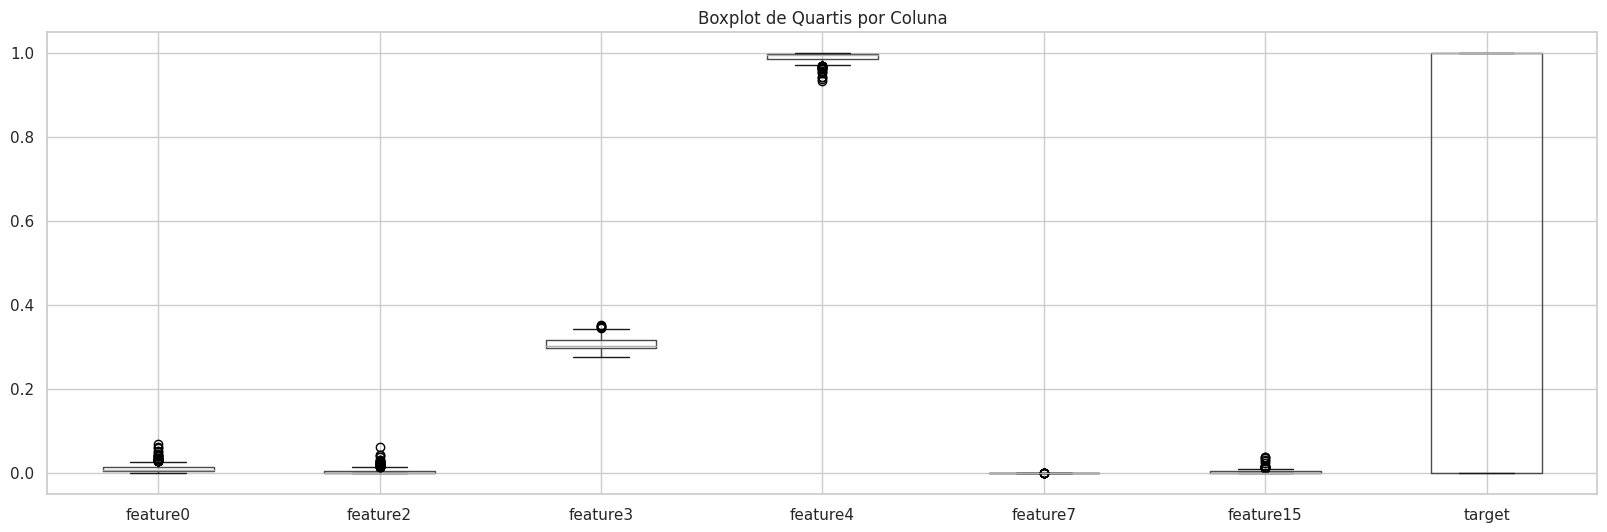

In [19]:
plt.figure(figsize=(20, 6))
df_corr.boxplot()
plt.title('Boxplot de Quartis por Coluna')
plt.show()

## Aumentar Dataset

In [20]:
# Aumente para no mínimo 2000 amostras
n_samples_needed = 2000

# Calcule quantas amostras adicionais são necessárias
n_additional_samples = n_samples_needed - len(df_visual)

# Reamostrar aleatoriamente o dataframe para criar amostras adicionais
additional_samples = df_visual.sample(n_additional_samples, replace=True)

# Concatenar o dataframe original com as amostras adicionais
df_augmented = pd.concat([df_visual, additional_samples], ignore_index=True)

# Exibir o novo dataframe com no mínimo 100 amostras
print(df_augmented)

      feature0  feature2  feature6  feature7  feature8  feature9  feature10  \
0     0.006494  0.000000  0.031628  0.000130  0.000000  0.018875   0.004908   
1     0.003247  0.002173  0.019437  0.000098  0.003290  0.014878   0.007531   
2     0.003247  0.010842  0.029327  0.000443  0.018879  0.005577   0.004046   
3     0.000000  0.000000  0.009463  0.000414  0.000000  0.001931   0.028215   
4     0.000000  0.000000  0.020290  0.000077  0.000000  0.018961   0.000476   
...        ...       ...       ...       ...       ...       ...        ...   
1995  0.006494  0.003959  0.008866  0.000072  0.006214  0.008809   0.004257   
1996  0.016234  0.017171  0.082864  0.000088  0.010067  0.069214   0.008014   
1997  0.025974  0.028188  0.187212  0.000138  0.010776  0.105708   0.013411   
1998  0.003247  0.000000  0.010486  0.000301  0.000000  0.002898   0.002875   
1999  0.000000  0.000000  0.016709  0.000462  0.000000  0.003055   0.000736   

      feature11  feature12  feature13  feature14  f

## Algoritmos

### Xgboost para seleção da melhror amostra do dataframe

In [21]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Suponha que você tenha vários DataFrames chamados df_normalizado, df_sem_outliers, df_visual, etc.
dataframes = [dataframe, df_normalizado, df_sem_outliers, df_visual, df_corr, df_fi, df_fs, df_rfe, df_augmented]

# Defina a semente para reprodutibilidade
seed = 42

for i, df in enumerate(dataframes):
    print(f"Testing DataFrame {i + 1}...")

    # Separate features and target variable
    X = df.drop("target", axis=1)
    y = df["target"]

    # Split data into training and testing sets with seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Create the XGBoost classifier with seed
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=100, learning_rate=0.1, max_depth=5, random_state=seed)

    # Perform cross-validation without seed
    cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

    # Train the model on the training set
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = xgb_model.predict(X_test)

    # Evaluate model performance on the test set
    accuracy_test = accuracy_score(y_test, y_pred)

    # Display information for each DataFrame
    print("Accuracy on test set:", accuracy_test)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation accuracy:", cv_scores.mean())
    print("\n")


Testing DataFrame 1...
Accuracy on test set: 0.5957446808510638
Cross-validation scores: [0.65957447 0.66666667 0.68817204 0.59139785 0.66666667]
Mean cross-validation accuracy: 0.6544955387783116


Testing DataFrame 2...
Accuracy on test set: 0.6276595744680851
Cross-validation scores: [0.68085106 0.66666667 0.66666667 0.60215054 0.65591398]
Mean cross-validation accuracy: 0.6544497826584305


Testing DataFrame 3...
Accuracy on test set: 0.7073170731707317
Cross-validation scores: [0.65853659 0.65853659 0.68292683 0.575      0.525     ]
Mean cross-validation accuracy: 0.62


Testing DataFrame 4...
Accuracy on test set: 0.7073170731707317
Cross-validation scores: [0.65853659 0.63414634 0.70731707 0.575      0.6       ]
Mean cross-validation accuracy: 0.635


Testing DataFrame 5...
Accuracy on test set: 0.7073170731707317
Cross-validation scores: [0.6097561  0.58536585 0.68292683 0.625      0.625     ]
Mean cross-validation accuracy: 0.625609756097561


Testing DataFrame 6...
Accuracy o

In [22]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Suponha que você tenha o DataFrame original chamado df_corr
X = df_fi.drop("target", axis=1)
y = df_fi["target"]

# Número de folds
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Iterar sobre os folds
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    if fold_idx == 2:  # Considerando o fold 3 (índice 2)
        X_fold, y_fold = X.iloc[test_idx], y.iloc[test_idx]
        break

# Aqui X_fold e y_fold são os conjuntos de teste específicos para o terceiro fold


### Rede Neural Baseada em Grafos GNN

In [23]:
!pip install torch torchvision torch-geometric  --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.5 MB/s eta 0:00:00


In [24]:
# Seleciona o datframe
df = df_visual

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/500 - Train Loss: 0.6899 - Val Loss: 0.6895 - Train Accuracy: 0.4617 - Val Accuracy: 0.6625
Epoch 5/500 - Train Loss: 0.6872 - Val Loss: 0.6861 - Train Accuracy: 0.4891 - Val Accuracy: 0.6625
Epoch 10/500 - Train Loss: 0.6846 - Val Loss: 0.6826 - Train Accuracy: 0.4922 - Val Accuracy: 0.6625
Epoch 15/500 - Train Loss: 0.6816 - Val Loss: 0.6793 - Train Accuracy: 0.4891 - Val Accuracy: 0.6625
Epoch 20/500 - Train Loss: 0.6777 - Val Loss: 0.6762 - Train Accuracy: 0.5070 - Val Accuracy: 0.6625
Epoch 25/500 - Train Loss: 0.6748 - Val Loss: 0.6732 - Train Accuracy: 0.5070 - Val Accuracy: 0.6625
Epoch 30/500 - Train Loss: 0.6701 - Val Loss: 0.6704 - Train Accuracy: 0.5164 - Val Accuracy: 0.6625
Epoch 35/500 - Train Loss: 0.6708 - Val Loss: 0.6678 - Train Accuracy: 0.4977 - Val Accuracy: 0.6625
Epoch 40/500 - Train Loss: 0.6636 - Val Loss: 0.6654 - Train Accuracy: 0.5234 - Val Accuracy: 0.6625
Epoch 45/500 - Train Loss: 0.6721 - Val Loss: 0.6632 - Train Accuracy: 0.4898 - Val Accuracy:

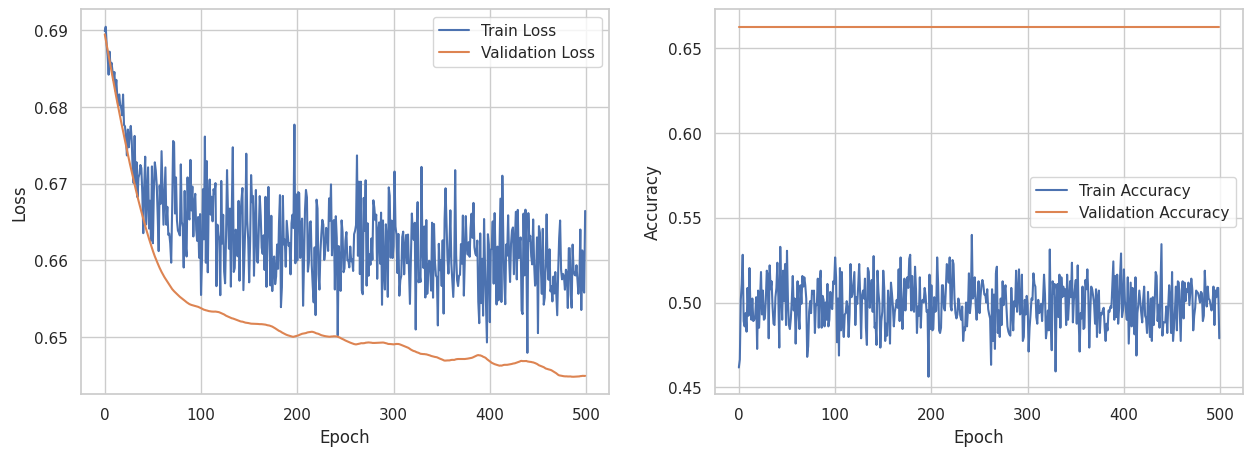

In [25]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = df_augmented # Mesmo dataframe df_visual apenas com pequeno aumento com pertubações 0.001

# Criar um grafo a partir do DataFrame
nodes = list(df.index)
edges = [(i, j) for i in range(len(df)) for j in range(len(df)) if i != j]

# Criar os recursos (features) dos nós
x = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float)

# Criar os índices das arestas
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Criar os rótulos dos nós
y = torch.tensor(df['target'].values, dtype=torch.float).view(-1, 1)  # Ajuste da forma para (n, 1)

# Criar um objeto Data para representar o grafo
graph_data = Data(x=x, edge_index=edge_index, y=y)

# Dividir os índices em conjuntos de treino, validação e teste
indices = list(range(len(df)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

# Criar conjuntos de dados de treino, validação e teste usando os índices específicos
train_data = graph_data.__class__(
    x=x[train_indices],
    edge_index=edge_index[:, ((edge_index[0] == train_indices) | (edge_index[1] == train_indices))],
    y=y[train_indices]
)

val_data = graph_data.__class__(
    x=x[val_indices],
    edge_index=edge_index[:, ((edge_index[0] == val_indices) | (edge_index[1] == val_indices))],
    y=y[val_indices]
)

test_data = graph_data.__class__(
    x=x[test_indices],
    edge_index=edge_index[:, ((edge_index[0] == test_indices) | (edge_index[1] == test_indices))],
    y=y[test_indices]
)

# Criar DataLoader para treino
train_loader = DataLoader([train_data], batch_size=1, shuffle=True)

# Definir a arquitetura da GNN com Dropout
class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = self.dropout2(x)
        return x

# Inicializar a GNN com Dropout
input_dim = df.shape[1] - 1  # Número de features excluindo o rótulo
hidden_dim = 16
output_dim = 1
dropout_prob = 0.5
gnn = SimpleGNN(input_dim, hidden_dim, output_dim, dropout_prob)

# Definir a função de perda e o otimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(gnn.parameters(), lr=0.001)

# Função para treinar a GNN e retornar as listas de perda e acurácia
# Função para treinar a GNN e retornar as listas de perda e acurácia
def train_gnn(gnn, train_loader, val_data, test_data, criterion, optimizer, epochs=500, patience=50, model_save_path='best_model.pth'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        gnn.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for data in train_loader:
            optimizer.zero_grad()
            output = gnn(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calcular acurácia de treino
            predicted_labels = (output > 0).float().view(-1).numpy()
            correct_train += accuracy_score(data.y.numpy(), predicted_labels, normalize=False)
            total_train += len(data.y)

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        gnn.eval()
        with torch.no_grad():
            val_output = gnn(val_data)
            val_loss = criterion(val_output, val_data.y).item()
            val_losses.append(val_loss)

            # Calcular acurácia de validação
            predicted_val_labels = (val_output > 0).float().view(-1).numpy()
            val_accuracy = accuracy_score(val_data.y.numpy(), predicted_val_labels)
            val_accuracies.append(val_accuracy)

            # Verificar a condição de parada antecipada
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stopping_counter = 0
                # Salvar o modelo atual como o melhor
                torch.save(gnn.state_dict(), model_save_path)
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print(f'Early stopping at epoch {epoch}. Best Validation Loss: {best_val_loss:.4f}')
                    break

            # Avaliar a GNN no conjunto de teste e plotar a matriz de confusão
            test_output = gnn(test_data)
            predicted_test_labels = (test_output > 0).float().view(-1).numpy()
            accuracy_test = accuracy_score(test_data.y.numpy(), predicted_test_labels)

            if epoch % 5 == 0:
                print(f'Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Accuracy: {val_accuracy:.4f}')

    # Carregar o melhor modelo ao final do treinamento
    gnn.load_state_dict(torch.load(model_save_path))

    # Plotar gráficos
    plt.figure(figsize=(15, 5))

    # Plotar loss de treino e validação no mesmo gráfico
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotar acurácia de treino e validação em outro gráfico
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    '''
    # Plotar matriz de confusão no conjunto de teste
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(test_data.y.numpy(), predicted_test_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    '''
# Treinar a GNN e obter as listas de perda e acurácia, salvando e carregando o melhor modelo
train_gnn(gnn, train_loader, val_data, test_data, criterion, optimizer, model_save_path='best_model.pth')



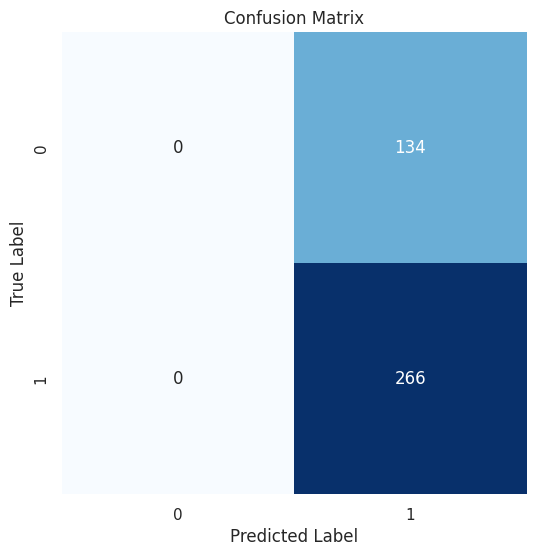

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       134
         1.0       0.67      1.00      0.80       266

    accuracy                           0.67       400
   macro avg       0.33      0.50      0.40       400
weighted avg       0.44      0.67      0.53       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Carregar o melhor modelo
gnn.load_state_dict(torch.load('best_model.pth'))


# Avaliar a GNN no conjunto de teste
gnn.eval()
with torch.no_grad():
    test_output = gnn(test_data)
    predicted_labels = (test_output > 0).float().view(-1).numpy()

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(test_data.y.numpy(), predicted_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calcular métricas de classificação (acurácia, recall, precisão, f1-score)
classification_report_str = classification_report(test_data.y.numpy(), predicted_labels)
print("Classification Report:\n", classification_report_str)


### Rede Neural Multi Camadas MLP

In [27]:
df = df_visual

In [28]:
# Dividindo em X e y
X = df.drop('target', axis=1)  # Features (todas as colunas, exceto a variável-alvo)
y = df['target']  # Variável-alvo

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Dividindo em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training for Fold 1:
Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.69231, saving model to best_model_weights.h5
4/4 - 15s - loss: 1.0399 - accuracy: 0.5146 - val_loss: 1.0375 - val_accuracy: 0.6923 - 15s/epoch - 4s/step
Epoch 2/500

Epoch 2: val_accuracy did not improve from 0.69231
4/4 - 0s - loss: 1.0363 - accuracy: 0.6019 - val_loss: 1.0349 - val_accuracy: 0.6923 - 134ms/epoch - 33ms/step
Epoch 3/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_accuracy did not improve from 0.69231
4/4 - 0s - loss: 1.0360 - accuracy: 0.5437 - val_loss: 1.0324 - val_accuracy: 0.6923 - 129ms/epoch - 32ms/step
Epoch 4/500

Epoch 4: val_accuracy did not improve from 0.69231
4/4 - 0s - loss: 1.0308 - accuracy: 0.6214 - val_loss: 1.0299 - val_accuracy: 0.6923 - 132ms/epoch - 33ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.69231
4/4 - 0s - loss: 1.0307 - accuracy: 0.6214 - val_loss: 1.0275 - val_accuracy: 0.6923 - 119ms/epoch - 30ms/step
Epoch 6/500

Epoch 6: val_accuracy did not improve from 0.69231
4/4 - 0s - loss: 1.0278 - accuracy: 0.6214 - val_loss: 1.0251 - val_accuracy: 0.6923 - 127ms/epoch - 32ms/step
Epoch 7/500

Epoch 7: val_accuracy did not improve from 0.69231
4/4 - 0s - loss: 1.0256 - accuracy: 0.6214 - val_loss: 1.0227 - val_accuracy: 0.6923 - 126ms/epoch - 31ms/step
Epoch 8/500

Epoch 8: val_accuracy did not improve from 0.69231
4/4 - 0s - loss: 1.0236 - accuracy: 0.6893 - val_loss: 1.0204 - val_accur

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


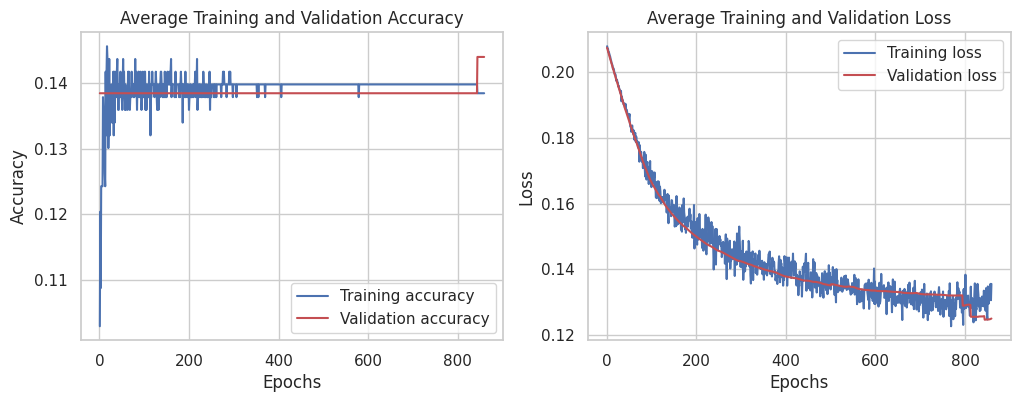

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

#Convertendo os DataFrames para arrays NumPy
X_train_np, y_train_np = X_train.values, y_train.values
X_test_np, y_test_np = X_test.values, y_test.values

# Dividindo o conjunto de treinamento em treino e validação
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_np, y_train_np, test_size=0.2, random_state=42)

# Definir a arquitetura da rede com dropout
model = Sequential([
    Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compilar o modelo com uma taxa de aprendizado menor
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Adicionar parada antecipada e checkpoint para salvar os melhores pesos
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Realizar K-fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

history_list = []  # Lista para armazenar os históricos de treinamento em cada fold

for train_index, val_index in kfold.split(X_train_split, y_train_split):
    print(f"\nTraining for Fold {fold}:")

    X_train_fold, X_val_fold = X_train_split[train_index], X_train_split[val_index]
    y_train_fold, y_val_fold = y_train_split[train_index], y_train_split[val_index]

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=500,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, model_checkpoint],
        verbose=2
    )

    history_list.append(history)  # Adicionar o histórico deste fold à lista

    # Avaliar o modelo no conjunto de validação deste fold
    fold_loss, fold_accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f'Fold {fold} - Loss: {fold_loss:.4f}, Accuracy: {fold_accuracy*100:.2f}%')

    fold += 1

# Carregar os melhores pesos antes da avaliação no conjunto de teste
model.load_weights('best_model_weights.h5')

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test_np, y_test_np)
print(f'\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_accuracy*100:.2f}%')


# Mostrar a acurácia e loss no final
train_acc = np.mean([fold_history.history['accuracy'] for fold_history in history_list], axis=0)
val_acc = np.mean([fold_history.history['val_accuracy'] for fold_history in history_list], axis=0)
train_loss = np.mean([fold_history.history['loss'] for fold_history in history_list], axis=0)
val_loss = np.mean([fold_history.history['val_loss'] for fold_history in history_list], axis=0)

epochs = range(1, len(train_acc) + 1)

# Imprimir a perda e acurácia formatadas
print(f'\nAverage Cross-Validation Metrics:')
print(f'Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]*100:.2f}%')
print(f'Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]*100:.2f}%')

plt.figure(figsize=(12, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


2/2 [==============================] - 0s 11ms/step - loss: 0.6199 - accuracy: 0.7317


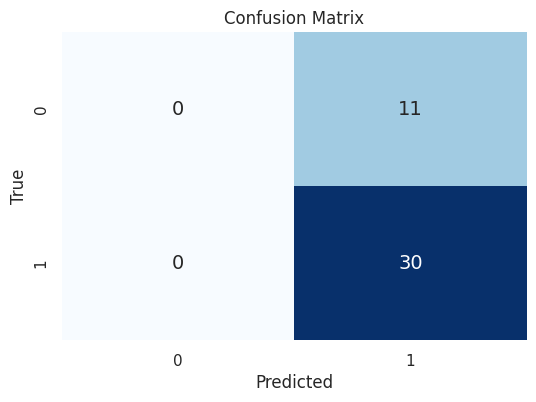




Test Set - Loss: 0.6199, Accuracy: 73.17%
Precision: 0.7317
Recall: 1.0000
F1 Score: 0.8451


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Avaliar o modelo no conjunto de teste
y_pred = model.predict(X_test_np)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calcular métricas
test_loss, test_accuracy = model.evaluate(X_test_np, y_test_np)
conf_matrix = confusion_matrix(y_test_np, y_pred_binary)
accuracy = accuracy_score(y_test_np, y_pred_binary)
precision = precision_score(y_test_np, y_pred_binary)
recall = recall_score(y_test_np, y_pred_binary)
f1 = f1_score(y_test_np, y_pred_binary)

# Mostrar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Imprimir métricas
print(f'\n\n\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_accuracy*100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

## Resultados

### GNN


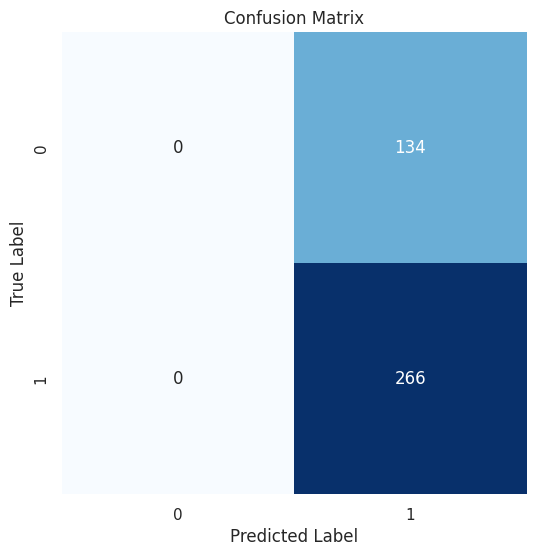

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       134
         1.0       0.67      1.00      0.80       266

    accuracy                           0.67       400
   macro avg       0.33      0.50      0.40       400
weighted avg       0.44      0.67      0.53       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Avaliar a GNN no conjunto de teste
gnn.eval()
with torch.no_grad():
    test_output = gnn(test_data)
    predicted_labels = (test_output > 0).float().view(-1).numpy()

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(test_data.y.numpy(), predicted_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calcular métricas de classificação (acurácia, recall, precisão, f1-score)
classification_report_str = classification_report(test_data.y.numpy(), predicted_labels)
print("Classification Report:\n", classification_report_str)


In [32]:
# Carregue outro conjunto de teste
# Pré-processamento do novo conjunto de teste
# Substitua as próximas linhas pelo pré-processamento do seu novo conjunto de teste
new_X_test = df_visual.drop('target', axis=1)  # Exemplo, ajuste conforme necessário
new_y_test = df_visual['target']

# Criar um grafo para o novo conjunto de teste
new_nodes = list(range(len(new_X_test)))
new_edges = [(i, j) for i in range(len(new_X_test)) for j in range(len(new_X_test)) if i != j]

new_x = torch.tensor(new_X_test.values, dtype=torch.float)
new_y = torch.tensor(new_y_test.values, dtype=torch.float).view(-1, 1)

new_edge_index = torch.tensor(new_edges, dtype=torch.long).t().contiguous()

new_graph_data = Data(x=new_x, edge_index=new_edge_index, y=new_y)

# Avaliar a GNN no novo conjunto de teste
gnn.eval()
with torch.no_grad():
    new_test_output = gnn(new_graph_data)
    new_predicted_labels = (new_test_output > 0).float().view(-1).numpy()

# Calcular a acurácia no novo conjunto de teste
new_accuracy = accuracy_score(new_graph_data.y.numpy(), new_predicted_labels)
print(f'Acurácia no novo conjunto de teste: {new_accuracy:.2f}')


Acurácia no novo conjunto de teste: 0.68


### MLP

2/2 [==============================] - 0s 10ms/step - loss: 0.6199 - accuracy: 0.7317

Test Set - Loss: 0.6199, Accuracy: 73.17%

Average Cross-Validation Metrics:
Training Loss: 0.1356, Training Accuracy: 13.85%
Validation Loss: 0.1250, Validation Accuracy: 14.40%


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


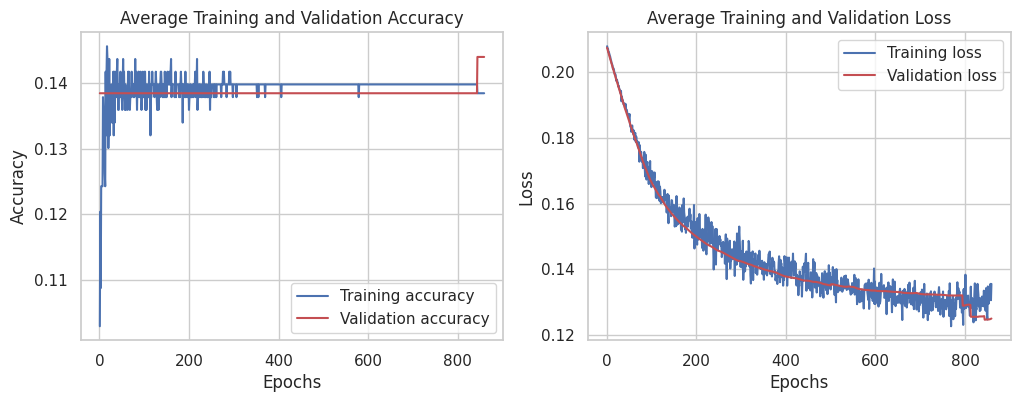

In [33]:
# Carregar os melhores pesos antes da avaliação no conjunto de teste
model.load_weights('best_model_weights.h5')

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test_np, y_test_np)
print(f'\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_accuracy*100:.2f}%')


# Mostrar a acurácia e loss no final
train_acc = np.mean([fold_history.history['accuracy'] for fold_history in history_list], axis=0)
val_acc = np.mean([fold_history.history['val_accuracy'] for fold_history in history_list], axis=0)
train_loss = np.mean([fold_history.history['loss'] for fold_history in history_list], axis=0)
val_loss = np.mean([fold_history.history['val_loss'] for fold_history in history_list], axis=0)

epochs = range(1, len(train_acc) + 1)

# Imprimir a perda e acurácia formatadas
print(f'\nAverage Cross-Validation Metrics:')
print(f'Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]*100:.2f}%')
print(f'Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]*100:.2f}%')

plt.figure(figsize=(12, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

2/2 [==============================] - 0s 10ms/step - loss: 0.6199 - accuracy: 0.7317


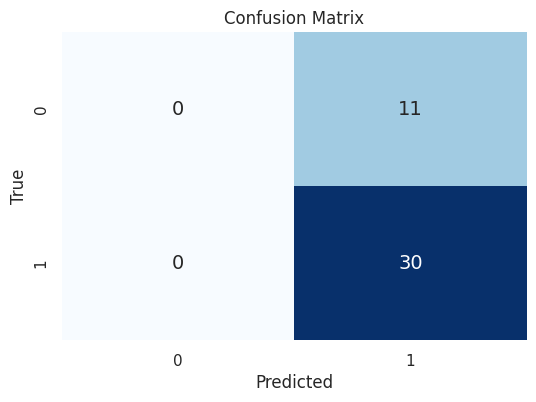




Test Set - Loss: 0.6199, Accuracy: 73.17%
Precision: 0.7317
Recall: 1.0000
F1 Score: 0.8451


In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Avaliar o modelo no conjunto de teste
y_pred = model.predict(X_test_np)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calcular métricas
test_loss, test_accuracy = model.evaluate(X_test_np, y_test_np)
conf_matrix = confusion_matrix(y_test_np, y_pred_binary)
accuracy = accuracy_score(y_test_np, y_pred_binary)
precision = precision_score(y_test_np, y_pred_binary)
recall = recall_score(y_test_np, y_pred_binary)
f1 = f1_score(y_test_np, y_pred_binary)

# Mostrar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Imprimir métricas
print(f'\n\n\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_accuracy*100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')